<a href="https://colab.research.google.com/github/YnaPqt/deploiement-getaround/blob/main/ml_pricing_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pricing Optimization using Machine Learning**

The primary goal is to maximize revenue per car while remaining competitive in the peer-to-peer car rental market. In order to ensure fair pricing per car bases on features and avoid underpricing(loss in potential revenue) and overpricing(lower bookings).

### **Import Modules**

In [406]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap

from sklearn.linear_model import LinearRegression,Ridge,ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('ggplot')

### **Dataset Overview**

In [2]:
data =  pd.read_csv('/content/get_around_pricing_project.csv').drop(columns='Unnamed: 0', axis=1)

In [3]:
data.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [4]:
data.columns

Index(['model_key', 'mileage', 'engine_power', 'fuel', 'paint_color',
       'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires', 'rental_price_per_day'],
      dtype='object')

# Get summary statistics and info

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

In [6]:
data.describe(include="all")

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4843,4.843000e+03,4843.00000,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843.000000
unique,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,969,NaN,NaN,4641,1633,1606,2662,3839,3865,3881,2613,3674,4514,NaN
mean,NaN,1.409628e+05,128.98823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.214536
std,NaN,6.019674e+04,38.99336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.568268
min,NaN,-6.400000e+01,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,1.029135e+05,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,NaN,1.410800e+05,120.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,NaN,1.751955e+05,135.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000


In [7]:
# Count of missing values
missing_counts = data.isnull().sum()

# Percentage of missing values
missing_percent = 100 * missing_counts / len(data)

# Count of unique values
unique_counts = data.nunique()

# Combine everything
summary = pd.DataFrame({
    'Data Type': data.dtypes,
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2),
    'Unique Values': unique_counts
})
print(summary)

                          Data Type  Missing Count  Missing %  Unique Values
model_key                    object              0        0.0             28
mileage                       int64              0        0.0           4786
engine_power                  int64              0        0.0             61
fuel                         object              0        0.0              4
paint_color                  object              0        0.0             10
car_type                     object              0        0.0              8
private_parking_available      bool              0        0.0              2
has_gps                        bool              0        0.0              2
has_air_conditioning           bool              0        0.0              2
automatic_car                  bool              0        0.0              2
has_getaround_connect          bool              0        0.0              2
has_speed_regulator            bool              0        0.0              2

In [8]:
# Count duplicate rows
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


**Check for Outliers**

In [9]:
# summary statistics of numeric columns
numeric_cols = ['mileage', 'engine_power', 'rental_price_per_day']

print(data[numeric_cols].describe())

            mileage  engine_power  rental_price_per_day
count  4.843000e+03    4843.00000           4843.000000
mean   1.409628e+05     128.98823            121.214536
std    6.019674e+04      38.99336             33.568268
min   -6.400000e+01       0.00000             10.000000
25%    1.029135e+05     100.00000            104.000000
50%    1.410800e+05     120.00000            119.000000
75%    1.751955e+05     135.00000            136.000000
max    1.000376e+06     423.00000            422.000000


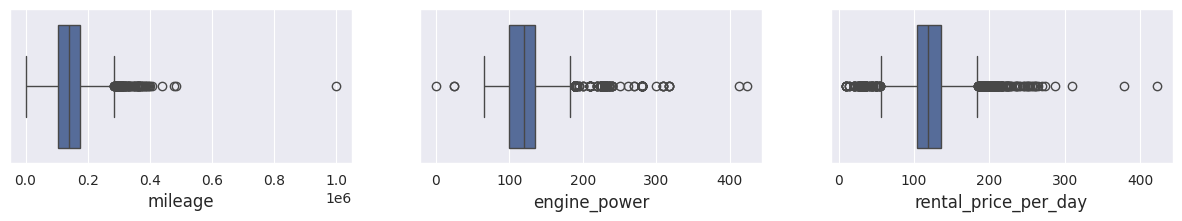

In [10]:
sns.set_style("darkgrid")
fig , ax = plt.subplots(1, 3, figsize=(15, 2))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data, x=col, ax=ax[i], color = '#4B68A4')
fig.show()



### **Remove Outliers**

In [117]:
df1= data.copy(deep=True)

In [122]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in ['mileage', 'engine_power', 'rental_price_per_day']:
    df1 = remove_outliers_iqr(df1, col)

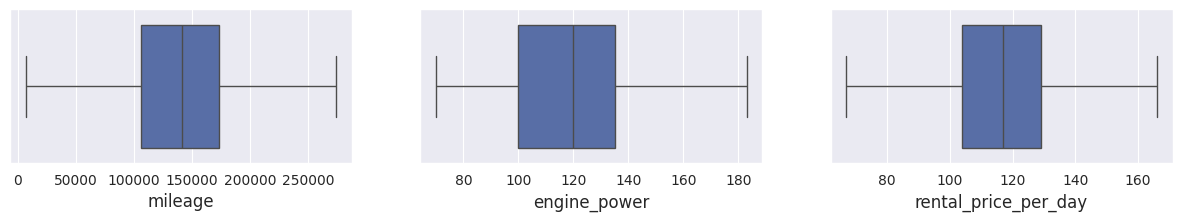

In [123]:
sns.set_style("darkgrid")
fig , ax = plt.subplots(1, 3, figsize=(15, 2))
for i, col in enumerate(numeric_cols):
    sns.boxplot(df1, x=col, ax=ax[i], color = '#4B68B3')
fig.show()


In [124]:
# Boolean to Integer
bool_cols = [
    'private_parking_available', 'has_gps', 'has_air_conditioning',
    'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires'
]
df1[bool_cols] = df1[bool_cols].astype(int)

## **Analyzing variables distributions vs target (Price)**

**Distribution of the Target**

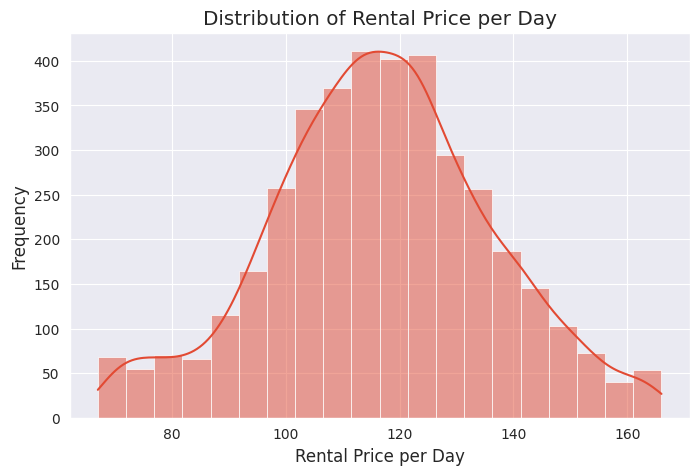

In [138]:
plt.figure(figsize=(8, 5))
sns.histplot(df1["rental_price_per_day"], bins=20, kde=True)
plt.title("Distribution of Rental Price per Day")
plt.xlabel("Rental Price per Day")
plt.ylabel("Frequency")
plt.show()


This distribution shows that most cars rent for between €90 and €140 per day, with the most frequent prices around €110–€120. The long tail to the right indicates a small segment of premium-priced vehicles. This validates our pricing model’s assumptions and suggests clear opportunities to find tresholds for cars and help owners optimize their revenue

## **Numeric Variables Vs Price**

In [125]:
# Create the scatter plot
fig = px.scatter(
    df1,
    x="mileage",
    y="rental_price_per_day",
    title="Mileage vs. Rental Price per Day",
    labels={
        "mileage": "Mileage",
        "rental_price_per_day": "Rental Price per Day"
    },
    color_discrete_sequence=["blue"],
    width=800,
    height=500
)

fig.show()

There is a weak negative trend overall:
As mileage increases, rental price tends to decrease slightly.

Wide dispersion:
For any given mileage (e.g., 50,000 km or 150,000 km), rental prices vary from ~80 to 160 per day, suggesting other factors (engine_power, model, car_type) play a bigger role.

No strong non-linear pattern (e.g., sharp drop-offs at high mileage).

In [126]:
# Create a new column with log-transformed mileage
df1["log_mileage"] = np.log1p(df1["mileage"])

In [127]:
# Create Scatterplot with log-transformed mileage
fig = px.scatter(
    df1,
    x="log_mileage",
    y="rental_price_per_day",
    title="Mileage vs. Rental Price per Day",
    labels={
        "mileage": "Mileage",
        "rental_price_per_day": "Rental Price per Day"
    },
    color_discrete_sequence=["blue"],
    width=800,
    height=500
)

fig.show()

The negative relationship is more apparent now:
As log(mileage) increases, the price tends to decrease in a clearer band.
The spread of data points has stabilized:
In the raw mileage plot, variance increased for higher mileage. Now the variance across the x-axis is more uniform.

The distribution is compressed horizontally, reducing the influence of very high mileage outliers.

In [128]:
# Create the scatter plot
fig = px.scatter(
    df1,
    x="engine_power",
    y="rental_price_per_day",
    title="Engine Power vs. Rental Price per Day",
    labels={
        "engine_power": "Engine Power",
        "rental_price_per_day": "Rental Price per Day"
    },
    color_discrete_sequence=["blue"],
    width=800,
    height=500
)

fig.show()

Weak positive trend overall:

- Higher engine power tends to be associated with somewhat higher rental prices, but the relationship is quite noisy.

Discrete values:

- Notice how engine power appears in bands (e.g., 90, 110, 130, 150). This is likely because cars are produced in standardized power steps (e.g., 90hp, 110hp).

Wide spread:
- Even within each engine power bucket, prices vary broadly (80–160), meaning engine power alone doesn’t strongly determine price.

No clear nonlinear cutoff (e.g., no sharp jump after 150hp).

The Engine Power can be binned into categories (“Low”, “Medium”, “High Power”) for simpler linear models or interpretability.

- Low: <100 hp

- Medium: 100–140 hp

- High: >140 hp

## **Categorical Variables vs. Price**

In [129]:
cat_cols = ["fuel", "paint_color", "car_type"]

# Box plots for fuel, paint_color, car_type
for col in cat_cols:
    fig = px.box(
        df1,
        x=col,
        y="rental_price_per_day",
        color=col,
        points=False,
        width=800,
        height=400,
        labels={
            col: col.replace("_", " ").title(),
            "rental_price_per_day": "Rental Price per Day"
        },
        title=f"Rental Price Distribution by {col.replace('_', ' ').title()}"
    )
    fig.update_layout(xaxis_tickangle=45, showlegend=False)
    fig.show()


# Box plot for top 10 model_key
top_models = df1["model_key"].value_counts().nlargest(10).index
df_top_models = df1[df1["model_key"].isin(top_models)]

fig = px.box(
    df_top_models,
    x="model_key",
    y="rental_price_per_day",
    color="model_key",
    points=False,
    width=1200,
    height=500,
    labels={
        "model_key": "Model Key",
        "rental_price_per_day": "Rental Price per Day"
    },
    title="Rental Price Distribution by Top 10 Car Models"
)
fig.update_layout(xaxis_tickangle=45, showlegend=False)
fig.show()


## **Rental Price per Day by Fuel Type**

Fuel type has a clear impact on rental price. Electric cars have a consistently higher median daily price (~145€) with low variability, indicating strong premium positioning. Diesel cars tend to be priced slightly higher than petrol, but both categories show wide price dispersion, suggesting that fuel type alone is not the sole driver of rental price. Other features and car characteristics remain important for pricing optimization.

## **Rental Price Distribution by Paint Color**

This analysis shows that paint color has relatively little impact on rental price, with most colors priced similarly around €115–€125 per day. However, orange cars are consistently priced higher (~€135 median), suggesting potential premium positioning, while green cars are priced lower. Overall, color should be considered a secondary factor in pricing strategy.

## **Rental Price Distribution by Car Type**

Car type is a major driver of rental price. Coupes consistently command the highest median price (~135 €), followed by sedans and SUVs (~125–130 €). Subcompacts are priced lowest (~105 € median). While price variability exists within each type, the car body style provides a clear segmentation for pricing strategy.

## **Rental Price Distribution by Top 10 Car Brands**

Car brand is a clear driver of rental pricing. Volkswagen and Audi cars achieve the highest median daily rental prices (130–140 €), while Citroën and Peugeot are generally mid-market (~110–115 €). BMWs and Mercedes show wider price dispersion due to fleet diversity. This insight supports using brand as a key variable in our pricing model and in owner revenue guidance.

##**Binary Features vs. Price**

In [137]:
binary_cols = [
    "private_parking_available",
    "has_gps",
    "has_air_conditioning",
    "automatic_car",
    "has_getaround_connect",
    "has_speed_regulator",
    "winter_tires"
]

for col in binary_cols:
    fig = px.box(
        df1,
        x=col,
        y="rental_price_per_day",
        width=600,
        height=400,
        labels={
            col: col.replace("_", " ").title(),
            "rental_price_per_day": "Rental Price per Day"
        },
        title=f"{col.replace('_', ' ').title()} vs. Rental Price per Day"
    )
    # hide legend since color is redundant
    fig.update_layout(showlegend=False)
    fig.show()


Private Parking Availability vs. Rental Price per Day

- Private parking availability has a measurable impact on rental pricing. Cars offering private parking command a median daily rate approximately €10 higher than those without, indicating increased convenience and perceived value to renters. However, substantial overlap in pricing suggests this feature should be considered alongside car type and other amenities.


Rental Price per Day by GPS Availability

- Cars equipped with GPS systems achieve median daily rental prices approximately €15 higher than those without. This suggests that renters are willing to pay a premium for in-vehicle navigation convenience, making GPS one of the most impactful features in pricing optimization.


Rental Price per Day by Air Conditioning Availability

- Cars equipped with air conditioning consistently achieve higher median rental prices (approximately €10–15 more per day). This confirms that climate control is perceived as a valuable amenity by renters, supporting its inclusion as a key variable in pricing optimization strategies

Rental Price per Day by Transmission Type

- Automatic transmission is associated with significantly higher rental prices. Cars with automatic gearboxes achieve median daily rates approximately €15–20 higher than manual cars, making this one of the most impactful features in our pricing model. This suggests a strong customer preference for automatic vehicles, which should be emphasized in pricing and marketing.


Rental Price per Day by Getaround Connect Availability

- Getaround Connect is a major driver of higher rental prices. Cars equipped with Connect achieve median daily rates ~€15–20 higher than those without, reflecting customer willingness to pay for convenient, self-service access. This supports prioritizing Connect adoption among car owners and highlighting it in marketing


Rental Price per Day by Speed Regulator Availability

- Cars equipped with speed regulators achieve median daily rates approximately €10–15 higher than those without, suggesting that customers value cruise control for added driving comfort. While the uplift is less pronounced than automatic transmission or Getaround Connect, it remains a consistent positive contributor to pricing.


Rental Price per Day by Winter Tires Availability

- Winter tires do not appear to meaningfully impact rental prices. Median daily rates are nearly identical for cars with and without winter tires, suggesting this feature is viewed as a safety requirement rather than a premium amenity


# **Preprocessing**

In [367]:
df2 =df1.copy(deep=True)

In [368]:
# Frequency encode model_key
model_freq = df2["model_key"].value_counts()
df2["model_key_freq"] = df2["model_key"].map(model_freq)


In [369]:
categorical_cols = ["fuel", "paint_color", "car_type"]
numeric_cols = ["engine_power"]

In [370]:
# Create ColumnTransformer
preprocessor = ColumnTransformer([
    # One-hot encode categoricals
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    # Standardize numeric columns (engine_power)
    ("num", StandardScaler(), numeric_cols),
    # Pass-through binary and pre-processed columns
    ("pass_binary", "passthrough", binary_cols + ["model_key_freq", "log_mileage"])
])

##**Training**

In [371]:
# Define features and target
X = df2.drop('rental_price_per_day', axis=1)
y = df2['rental_price_per_day']

In [372]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Linear Regression**

In [373]:
# Create Linear Reg Pipeline
linear_reg_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

In [374]:
linear_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['fuel', 'paint_color',
                                                   'car_type']),
                                                 ('num', StandardScaler(),
                                                  ['engine_power']),
                                                 ('pass_binary', 'passthrough',
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_getaround_connect',
                                                   'has_speed_regulator',
                                                   'winter_tires',
                                                   'model_key_freq',
                                                   'log_mileage'])])),
                ('model', LinearRegression())])

In [377]:
y_pred_reg = linear_reg_pipeline.predict(X_test)

In [378]:
mae_reg = mean_absolute_error(y_test, y_pred_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2_reg = r2_score(y_test, y_pred_reg)
print(f"MAE: {mae_reg:.2f}")
print(f"RMSE: {rmse_reg:.2f}")
print(f"R² Score: {r2_reg:.2f}")

MAE: 9.91
RMSE: 13.52
R² Score: 0.52


### **ElasticNetCV**

In [381]:
# Define ElasticNetCV with 5-fold cross-validation
elastic_model = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9],
    alphas=np.logspace(-2, 2, 10,20),
    cv=5,
    random_state=42
)

In [382]:
# Build pipeline
elastic_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", elastic_model)
])

In [383]:
elastic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['fuel', 'paint_color',
                                                   'car_type']),
                                                 ('num', StandardScaler(),
                                                  ['engine_power']),
                                                 ('pass_binary', 'passthrough',
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_getaround_connect',
                                                   'has_speed_regulator',
                                                   'winter_tires',
                                                   'model_key_freq',
                                                   'log_mileage'])])),
                ('model',
                 ElasticNetCV(alphas=array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                              cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9],
                              random_state=42))])

In [384]:
# Model evaluation
y_pred_elastic = elastic_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_elastic)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
r2 = r2_score(y_test, y_pred_elastic)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 9.90
RMSE: 13.51
R² Score: 0.52


# **Random Forest Regressor**

In [385]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

In [386]:
# Pipeline
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", rf_model)
])

In [387]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['fuel', 'paint_color',
                                                   'car_type']),
                                                 ('num', StandardScaler(),
                                                  ['engine_power']),
                                                 ('pass_binary', 'passthrough',
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_getaround_connect',
                                                   'has_speed_regulator',
                                                   'winter_tires',
                                                   'model_key_freq',
                                                   'log_mileage'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, n_estimators=200,
                                       n_jobs=-1, random_state=42))])

In [388]:
y_pred_rf = rf_pipeline.predict(X_test)

In [390]:
# Metrics
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 8.53
RMSE: 12.14
R² Score: 0.61


## **XGboost Model**

In [391]:
# XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [392]:
xgb_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", xgb_model)
])

In [393]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['fuel', 'paint_color',
                                                   'car_type']),
                                                 ('num', StandardScaler(),
                                                  ['engine_power']),
                                                 ('pass_binary', 'passthrough',
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_getaround_connect',
                                                   'has_speed_regu...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [394]:
y_pred_xgb = xgb_pipeline.predict(X_test)

In [395]:
# Metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 8.07
RMSE: 11.30
R²: 0.66


## **Voting Regressor**

In [396]:
voting = VotingRegressor(
    estimators=[
        ("elasticnet", elastic_model),
        ("random_forest", rf_model),
        ("xgboost", xgb_model)
    ]
)

In [397]:
voting_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", voting)
])

In [398]:
voting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['fuel', 'paint_color',
                                                   'car_type']),
                                                 ('num', StandardScaler(),
                                                  ['engine_power']),
                                                 ('pass_binary', 'passthrough',
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_getaround_connect',
                                                   'has_speed_regu...
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.05,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=6,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=300,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))])

In [399]:
y_pred_voting= voting_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_voting)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_voting))
r2 = r2_score(y_test, y_pred_voting)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 8.25
RMSE: 11.57
R²: 0.65


# **Comparing Models' Performances**

In [400]:
# Results dictionary
results = {
    "Model": [
        "Linear Regression",
        "ElasticNet",
        "Random Forest",
        "XGBoost",
        "Voting Regressor"
    ],
    "MAE": [
        9.91,   # Linear Regression
        9.90,   # ElasticNet
        8.53,   # Random Forest
        8.07,   # XGBoost
        8.25    # Voting Regressor
    ],
    "RMSE": [
        13.52,
        13.51,
        12.14,
        11.30,
        11.57
    ],
    "R2": [
        0.52,
        0.52,
        0.61,
        0.66,
        0.65
    ]
}

In [401]:
# Create DataFrame
results_df = pd.DataFrame(results)

# Sort by R2 descending
results_df = results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)

print(results_df)

               Model   MAE   RMSE    R2
0            XGBoost  8.07  11.30  0.66
1   Voting Regressor  8.25  11.57  0.65
2      Random Forest  8.53  12.14  0.61
3  Linear Regression  9.91  13.52  0.52
4         ElasticNet  9.90  13.51  0.52


/tmp/ipython-input-402-3192114244.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-402-3192114244.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-402-3192114244.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




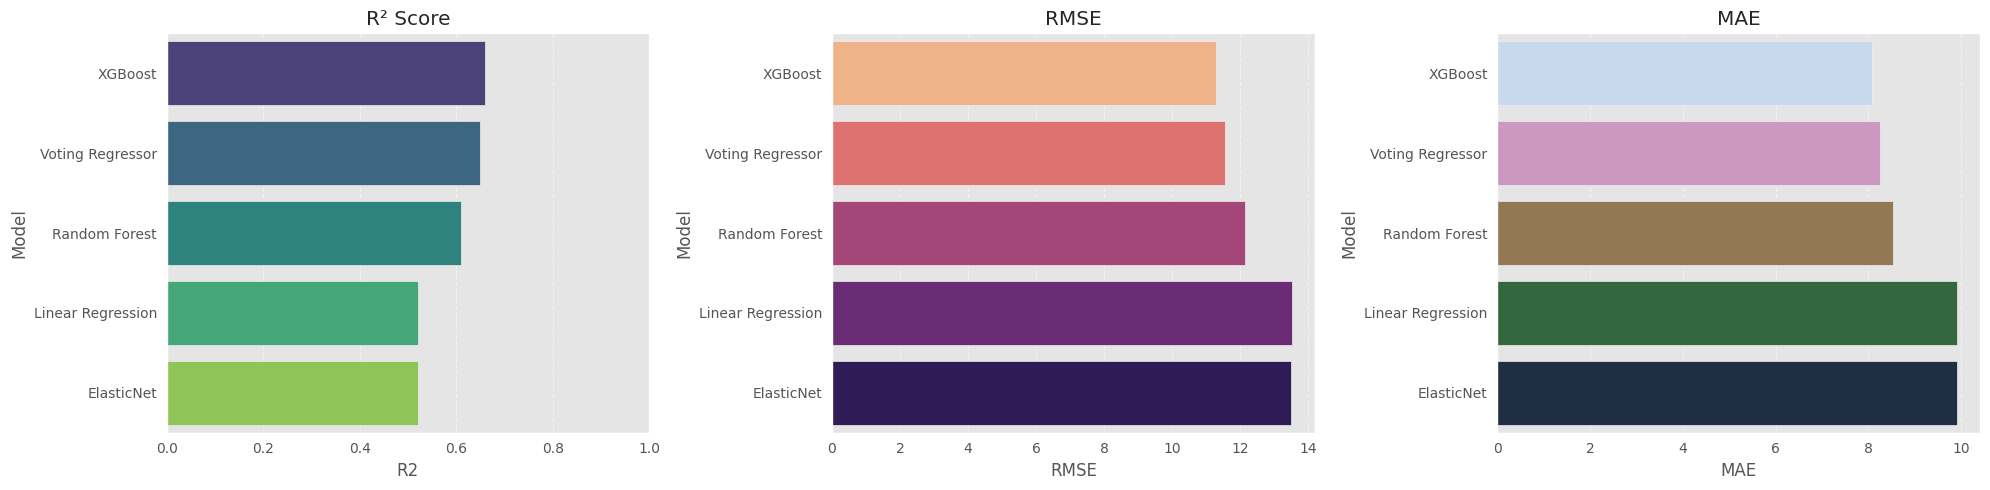

In [402]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

# R2
sns.barplot(
    data=results_df,
    x="R2",
    y="Model",
    ax=axes[0],
    palette="viridis"
)
axes[0].set_title("R² Score")
axes[0].set_xlim(0,1)
axes[0].grid(axis="x", linestyle="--", alpha=0.5)

# RMSE
sns.barplot(
    data=results_df,
    x="RMSE",
    y="Model",
    ax=axes[1],
    palette="magma_r"
)
axes[1].set_title("RMSE")
axes[1].grid(axis="x", linestyle="--", alpha=0.5)

# MAE
sns.barplot(
    data=results_df,
    x="MAE",
    y="Model",
    ax=axes[2],
    palette="cubehelix_r"
)
axes[2].set_title("MAE")
axes[2].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


## **Feature Importance XGBOOST**

In [403]:
importances = xgb_pipeline.named_steps["model"].feature_importances_

# Get feature names
ohe = xgb_pipeline.named_steps["preprocessing"].named_transformers_["onehot"]
ohe_features = ohe.get_feature_names_out(categorical_cols)
feature_names = list(ohe_features) + numeric_cols + binary_cols + ["model_key_freq", "log_mileage"]

# Combine
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(importances_df)

                      Feature  Importance
23      has_getaround_connect    0.123897
18               engine_power    0.114095
20                    has_gps    0.066778
22              automatic_car    0.060054
26             model_key_freq    0.054627
27                log_mileage    0.053581
0                fuel_electro    0.043753
12            car_type_estate    0.041602
16               car_type_suv    0.040153
1                 fuel_petrol    0.034014
14             car_type_sedan    0.033000
15        car_type_subcompact    0.031511
13         car_type_hatchback    0.030839
24        has_speed_regulator    0.029684
11             car_type_coupe    0.029356
5           paint_color_green    0.027626
25               winter_tires    0.022809
10          paint_color_white    0.019815
3            paint_color_blue    0.019563
19  private_parking_available    0.018758
9          paint_color_silver    0.017682
21       has_air_conditioning    0.017487
17               car_type_van    0

In [404]:
fig = px.bar(
    importances_df,
    x="Importance",
    y="Feature",
    orientation="h",
    color="Importance",
    color_continuous_scale=px.colors.sequential.Emrld,
    category_orders={"Feature": importances_df["Feature"].tolist()},
    width=800,
    height=600,
    labels={"Importance": "Importance", "Feature": "Feature"},
    title="XGBoost Feature Importances"
)

fig.update_layout(
    template="plotly_white",
    margin=dict(l=200, r=20, t=60, b=40),
    showlegend=False
)

fig.update_xaxes(title_text="Importance")
fig.update_yaxes(title_text="")

fig.show()


 Most Influential Predictors:

  - has_getaround_connect: The biggest single driver of price uplift—cars with Getaround Connect command significantly higher prices.

  - engine_power: More powerful cars rent for more.

  - has_gps & automatic_car: Features increasing convenience justify higher daily rates.

  - model_key_freq: Popular car models rent for more (capturing brand/market preference).

  - log_mileage: Higher mileage slightly reduces price.

  - fuel_electro: Electric cars have a premium.

  - car_type: Estates and SUVs are priced higher.

Less Important Predictors:

  - Specific paint colors (minimal impact).

  - Some binary features like winter tires and air conditioning.

This tells that:

-  Equipping cars with Getaround Connect, GPS, and automatic transmission is the single most impactful lever to increase revenue.
- Engine power and car type also strongly drive higher pricing.
- Mileage and model popularity remain important signals, but are less controllable.